# **Introduction**

Independent Component Analysis is a technique often used in source-signal separation problems, such as in the cocktail party problem where we are trying to isolate a specific source out of multiple. Similar processes occur in our cochleas, which decomposes a single single into independent components. 

The technique of ICA is characterized by trying to maximize the statistical independence of non-gaussian data. Because of this phenomenon, we can use the equation: 

$$ x = As $$

where x is the data being represented by the basis matrix A multiplied by a vector of coefficients, s, in order to find a mixing matrix for the independent signals. 

In this notebook we will be using the LIBRISPEECh dataset sourced from torchaudio's avaialable datasets. We will also be implementing the fast_ICA algorithm discussed in Independent Component Analysis (Hyvärinen et al., 2001). 

# **Implementation**

We begin by installing our dependencies and loading in the data from torchaudio, before taking a subset of the data to run the algorithm on.  


In [ ]:
pip install torchaudio

In [ ]:
#importing packages 
import io 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import torchaudio 
import torch
from google.colab import files



In [ ]:
#loading in the data - sourced from torchaudio's dataset utilities
data = torchaudio.datasets.LIBRISPEECH(root = '/.', download=True)


In [ ]:
#Take a subset of the entire dataset
subset = torch.utils.data.Subset(data, np.arange(0, 50))

data_loader = torch.utils.data.DataLoader(subset,
                                          batch_size=1,
                                          shuffle=True)
ds = []
for d in data_loader: 
  ds.append(d[0].numpy()[0][0])

for sample in ds: 
  sample = sample[:128]

#We take a sample of 128 points based on the methods in Lewicki's study 
dataset = [s[:128] for s in ds]

#convert datset into an nparray 
audio = np.array(dataset)




In [ ]:
#Helper functions for the ICA algorithm 
def g(x): 
  return np.tanh(x)

def g_prime(x): 
  return (1 - np.square(np.tanh(x)))

def norm(x): 
  return x /  np.sqrt((x ** 2).sum())

def update_weights(weights, x): 
  s = np.dot(weights.T, x)
  update = (x*g(s)).mean(axis=1) - g_prime(s).mean()*weights.squeeze()
  update = norm(update)
  return update


Update weights is the learning rule we will use in this implementation of ICA. The functions g and g' are taken from Independent Component Analysis (2001) as a way to maximize non-gaussianity of the data. We will use this learning rule in a feed-forward step to udpate the weights for our mixing matrix. 

In [ ]:
#Implementation of the fast_ICA algorithm as described in Independent Component Analysis (Hyvärinen, 2001)

def fast_ica(signal, max_iter = 100, threshold = 0.00001):
  
  m = len(signal)
  
  A = np.random.rand(m, m)

  for i in range(m): 
    
    weight = A[i,:].copy().reshape(m, 1)
    weight = norm(weight)

    for j in range(max_iter): 
      
      new_weight = update_weights(weight, signal)
      new_weight -= np.dot(np.dot(new_weight, A[:i].T), A[:i])
      new_weight = norm(new_weight)

      dist = np.abs(np.dot(weight.T, new_weight) - 1)

      weight = new_weight 

      if (dist < threshold): 
        break 

    A[i, :] = weight
  return A 



In [ ]:
W = fast_ica(audio)
#Un-mix signals using
unMixed = audio.T.dot(W.T)

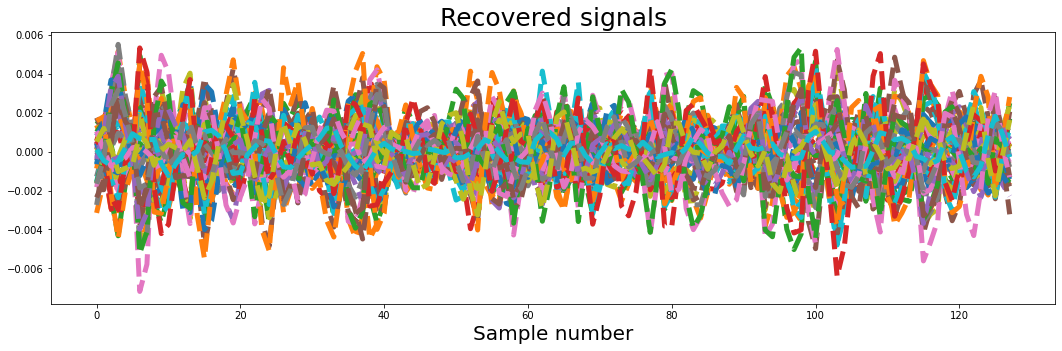

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)

plt.show()

As we can see after running the algorithm on our given dataset, we are able to find a mixing matrix for the sources. Analyzing the results shows that we are able to retrieve the independent components for human vocalizations. The resulting waveforms also show similar characteristics to the results in Lewicki's paper, which is a mix of animal and nature sound harmonics. The paper's interesting result yields more insight into how speech may have evolved, in the domain in between natural sounds and animal vocalizations which early humans may have possessed. 

*Side Note: I couldn't figure out how to graph the signals on separate charts, apologies for the poor visualization practices*

# **Sources**

A. Hyvärinen, J. Karhunen, and E. Oja. Independent Component Analysis. Wiley-Interscience, New York, NY, 1st edition, May 2001.

Lewicki, Michael S. Efficient Coding of Natural Sounds. Nature Neuroscience, vol. 5, no. 4, 2002, pp. 356-363., doi:10.1038/nn831.  